In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip'

Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip
replace train_cropped_images/4689_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip
replace test_cropped_images/4999_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip
replace val_cropped_images/4761_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:

# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the pre-trained weights
base_model.trainable = False

# Pass the input layer through the pre-trained model
features = base_model.output

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dense(units=8, activation='softmax')(outputs)

In [5]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# f1_score = tfa.metrics.F1Score(num_classes=8)
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [6]:

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[categorical_accuracy, precision , recall])

In [7]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [8]:

# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023/Single_disease'
train_df = pd.read_excel(f'{base_path}/train_labels.xlsx')
test_df = pd.read_excel(f'{base_path}/test_labels.xlsx')
val_df = pd.read_excel(f'{base_path}/val_labels.xlsx')


/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [9]:
train_df

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Fundus,Diagnostic_Keywords,N,D,G,C,A,H,M,O
0,0,0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0
1,1,1,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0
2,3,3,3,3_left.jpg,normal fundus,1,0,0,0,0,0,0,0
3,4,4,4,4_left.jpg,macular epiretinal membrane,0,0,0,0,0,0,0,1
4,5,5,5,5_left.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455,6953,3477,3494,4683_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
6456,6954,3478,3495,4686_right.jpg,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
6457,6955,3479,3496,4688_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
6458,6956,3480,3497,4689_right.jpg,normal fundus,1,0,0,0,0,0,0,0


# Train

In [11]:
labels = train_df.iloc[:, 3:].values

In [12]:
labels

array([['0_left.jpg', 'cataract', 0, ..., 0, 0, 0],
       ['1_left.jpg', 'normal fundus', 1, ..., 0, 0, 0],
       ['3_left.jpg', 'normal fundus', 1, ..., 0, 0, 0],
       ...,
       ['4688_right.jpg', 'moderate non proliferative retinopathy', 0,
        ..., 0, 0, 0],
       ['4689_right.jpg', 'normal fundus', 1, ..., 0, 0, 0],
       ['4690_right.jpg', 'mild nonproliferative retinopathy', 0, ..., 0,
        0, 0]], dtype=object)

In [13]:
# Split the data into two arrays, one for the image paths and one for the labels
train_images_base_path = '/content/train_cropped_images/'
image_paths = train_images_base_path + train_df["Fundus"].values
labels = train_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Test

In [14]:

# Split the data into two arrays, one for the image paths and one for the labels
test_images_base_path = '/content/test_cropped_images/'
image_paths = test_images_base_path + test_df["Fundus"].values
labels = test_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Validation

In [16]:
# Split the data into two arrays, one for the image paths and one for the labels
val_images_base_path = '/content/val_cropped_images/'
image_paths = val_images_base_path + val_df["Fundus"].values
labels = val_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [17]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [18]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [19]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [20]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [21]:
# Train the model
history=model.fit(train_dataset, epochs=20, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/20
202/202 [==============================] - 149s 596ms/step - loss: 3.3172 - categorical_accuracy: 0.4836 - precision: 0.4924 - recall: 0.4757 - val_loss: 4.3085 - val_categorical_accuracy: 0.4448 - val_precision: 0.4503 - val_recall: 0.4374
Epoch 2/20
202/202 [==============================] - 116s 520ms/step - loss: 1.6941 - categorical_accuracy: 0.6235 - precision: 0.6321 - recall: 0.6133 - val_loss: 4.3939 - val_categorical_accuracy: 0.4321 - val_precision: 0.4337 - val_recall: 0.4268
Epoch 3/20
202/202 [==============================] - 115s 526ms/step - loss: 1.0615 - categorical_accuracy: 0.7088 - precision: 0.7186 - recall: 0.6952 - val_loss: 3.9709 - val_categorical_accuracy: 0.3811 - val_precision: 0.3854 - val_recall: 0.3747
Epoch 4/20
202/202 [==============================] - 114s 512ms/step - loss: 0.6356 - categorical_accuracy: 0.7972 - precision: 0.8101 - recall: 0.7876 - val_loss: 3.3421 - val_categorical_accuracy: 0.4257 - val_precision: 0.4314 - val_recall:

In [28]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_vgg16_s.h5')

In [23]:
import matplotlib.pyplot as plt

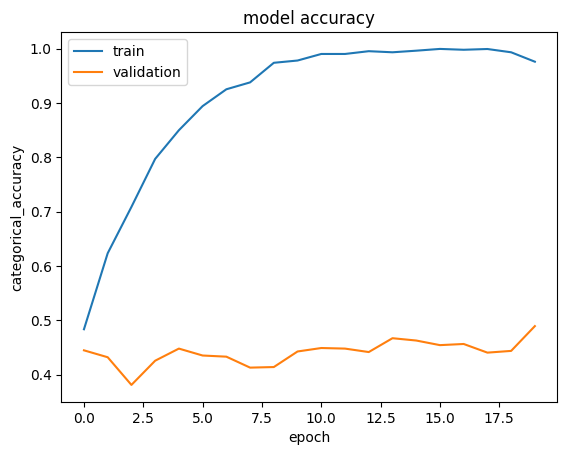

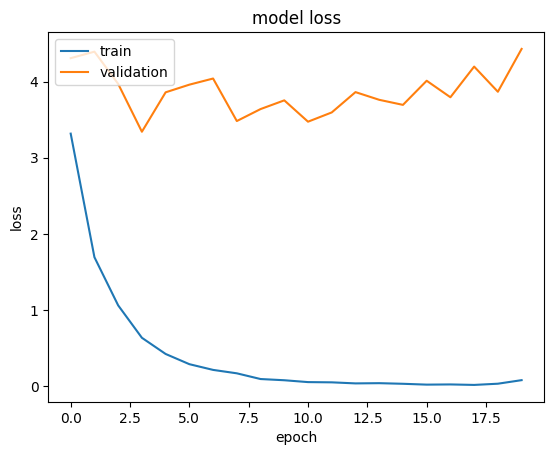

In [24]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
result = model.evaluate(test_dataset)
result

60/60 [==============================] - 36s 402ms/step - loss: 4.6522 - categorical_accuracy: 0.4810 - precision: 0.4855 - recall: 0.4773


[4.652179718017578,
 0.4809926152229309,
 0.48549947142601013,
 0.47729673981666565]

In [26]:
# load_model = tf.keras.saving.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_4.h5',compile=False)

In [27]:
import numpy as np

# Assuming you have a test dataset 'test_data' with image tensors and corresponding labels
predictions = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Compute the confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)

# Convert the confusion matrix to a NumPy array and print it
print("Confusion Matrix:")
print(cm.numpy())


1/1 [==============================] - 0s 237ms/step
Confusion Matrix:
[[709  71   3   1   7   3   4  21]
 [127  39   0   0   2   4   1   5]
 [ 55   5   5   0   0   0   0   0]
 [ 16   1   0  64   0   0   0   0]
 [ 51   7   0   1   7   0   0   4]
 [ 19   6   0   0   0   1   0   1]
 [ 15   3   0   1   1   0  33   5]
 [368  78   4  16  20   4  53  53]]
